# **Bachelor's Project - CAN Attacks Detection**

## Data Cleaning

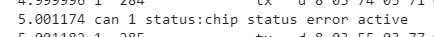

Handling labels. Removed lines with data that is not useful.

In [2]:
with open('output.txt') as f:
    output = f.read()
output=output.lower()
output=output.splitlines()
output=output[5:-1]
labels=[]
for line in output:
  if "not" in line:
    labels.append('not intrusion')
  else:
    labels.append('intrusion')

labels[1000:1010]
#print(len(labels))

['not intrusion',
 'not intrusion',
 'not intrusion',
 'not intrusion',
 'not intrusion',
 'not intrusion',
 'not intrusion',
 'intrusion',
 'not intrusion',
 'not intrusion']

Cleaned data. Removed description of data.

In [3]:
with open('trace.asc') as f:
    trace = f.read()
trace=trace.lower()
trace=trace.splitlines()
trace=trace[5:]
data=[]
for line in trace:
  line=line.replace("length","")
  line=line.replace("=","")
  line=line.replace("bitcount","")
  line=line.replace("id","")
  if "error" not in line:
    data.append(line)

data[1000:1010]
#print(len(result))

['   1.542841 1  1f9             tx   d 6 20 1e 1c 1e f8 ff    200000   103   505',
 '   1.542856 1  181             tx   d 8 1c 1e 34 10 32 20 41 4e    234000   120   385',
 '   1.548734 1  1a5             tx   d 8 3f ff 01 00 00 00 00 00    242000   124   421',
 '   1.550585 1  244             tx   d 7 fe fe 00 00 00 00 fe    222000   114   580',
 '   1.552317 1  161             tx   d 5 32 23 5e 00 10    172000   89   353',
 '   1.552325 1  1f9             tx   d 6 20 1e 1c 1e f8 ff    200000   103   505',
 '   1.552327 1  181             tx   d 8 1c 1e 34 10 32 20 41 4e    234000   120   385',
 '   1.554310 1  1a5             tx   d 8 bc bf ba 4c 84 5a df 5b    220000   113   421',
 '   1.558692 1  1a5             tx   d 8 4f ff 01 00 00 00 00 00    238000   122   421',
 '   1.560845 1  284             tx   d 8 00 00 00 00 00 00 00 00    246000   126   644']

Splitting lines in 'words'. Adding extra '00' bytes as padding for messages that have length smaller than 8.
For the final data structure we'll have the following format:
1. Time  
2. Channel   
3. MessageID(hex)   
4. Type (Rx/Tx)  
5. ???   
6. LengthOfMessage   
7. Byte1   
8. Byte2   
9. Byte3   
10. Byte4   
11. Byte5   
12. Byte6   
13. Byte7   
14. Byte8
15. Length
16. Bitcound
17. MessageID(decimal)

In [4]:
temp=[]
for line in data:
  line=line.split()
  message_length=int(line[5])
  if(message_length<8):
    for i in range(8-message_length):
      line.insert(6+message_length+i,'00')
  temp.append(line)
data=temp

print(data[:5])

[['0.000116', '1', '284', 'tx', 'd', '8', '00', '00', '00', '00', '00', '00', '00', '00', '246000', '126', '644'], ['0.000486', '1', '285', 'tx', 'd', '8', '00', '00', '00', '00', '00', '00', '00', '00', '248000', '127', '645'], ['0.003600', '1', '161', 'tx', 'd', '5', '32', '22', '5d', '00', '10', '00', '00', '00', '176000', '91', '353'], ['0.003608', '1', '1f9', 'tx', 'd', '6', '20', '1e', '1c', '7e', 'f8', 'ff', '00', '00', '194000', '100', '505'], ['0.003632', '1', '181', 'tx', 'd', '8', '1c', '7e', '32', '10', '32', '20', '42', '4e', '228000', '117', '385']]


##Creating Dataset

In [5]:
import numpy as np
import pandas as pd

In [6]:
data = pd.DataFrame(data, columns=['Time', 'Channel','ID_Hex','Type','???','ByteNo','b1','b2','b3','b4','b5','b6','b7','b8','Length','Bitcount','ID'])
data=data.drop('Channel',axis=1)
data=data.drop('???',axis=1)
data=data.drop('ID_Hex',axis=1)
data=data.drop('Type',axis=1)
data[['b1','b2','b3','b4','b5','b6','b7','b8']]=data[['b1','b2','b3','b4','b5','b6','b7','b8']].applymap(lambda x: int(x, 16))
data[['ByteNo','Length','Bitcount','ID']]=data[['ByteNo','Length','Bitcount','ID']].applymap(lambda x:int(x,10))
data['Time']=data['Time'].astype(float)

In [7]:
data

,Time,ByteNo,b1,b2,b3,b4,b5,b6,b7,b8,Length,Bitcount,ID
0,0.000116,8,0,0,0,0,0,0,0,0,246000,126,644
1,0.000486,8,0,0,0,0,0,0,0,0,248000,127,645
2,0.003600,5,50,34,93,0,16,0,0,0,176000,91,353
3,0.003608,6,32,30,28,126,248,255,0,0,194000,100,505
4,0.003632,8,28,126,50,16,50,32,66,78,228000,117,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,5.989749,8,255,255,1,0,0,0,0,0,240000,123,421
3889,5.991816,7,254,254,0,0,0,0,254,0,222000,114,580
3890,5.993806,5,71,35,150,0,47,0,0,0,172000,89,353
3891,5.993821,6,32,30,57,198,248,255,0,0,192000,99,505


In [8]:
data=np.array(data)
labels=np.array(labels)


##Classification

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=0)

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("kNN model accuracy:", metrics.accuracy_score(y_test, y_pred))

kNN model accuracy: 0.9948630136986302


In [12]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
true_negative=confusion_matrix[0][0]
false_positive=confusion_matrix[0][1]
false_negative=confusion_matrix[1][0]
true_positive=confusion_matrix[1][1]

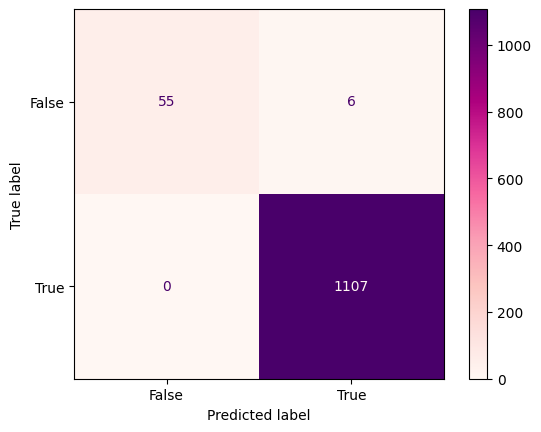

In [13]:
cmap=plt.get_cmap('RdPu')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap=cmap)
plt.show()

In [19]:
TPR=true_positive/(true_positive+false_negative)   #true positive rate
TNR=true_negative/(true_negative+false_positive)   #true negative rate
PPV=true_positive/(true_positive+false_positive)   #positive predictive value / precision
NPV=true_negative/(true_negative+false_negative)   #negative predictive value
FNR=false_negative/(false_negative+true_positive)  #false negative rate
FPR=false_positive/(false_positive+true_negative)  #false positive rate
FDR=false_positive/(false_positive+true_positive)  #false discovery rate
FOR=false_negative/(false_negative+true_negative)  #false omission rate
LRP=TPR/FPR #positive likelihood ratio
LRM=FNR/TNR #negative likelihood ratio
PT=0
TS=true_positive/(true_positive+false_negative+false_positive) #threat score/critical success index
ACC=(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative) #accuracy

In [21]:
print('Accuracy:'+ str(ACC))

Accuracy:0.9948630136986302
